Loading My Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Preprocessing Datasets

## FairFace

Loading FairFace Dataset Package From HuggingFace

In [ ]:
!pip install datasets # For accessing huggingface
from datasets import load_dataset
from datasets import concatenate_datasets
import pandas as pd
import random

# Load FairFace train split
dataset = load_dataset("HuggingFaceM4/FairFace", "1.25", split='train')


Extracting 1750 Images from Fairface with balanced gender & race ratio

In [ ]:
from datasets import concatenate_datasets

balanced = []
target_per_group = 125

for race in dataset.unique('race'):
    for gender in dataset.unique('gender'):
        subset = dataset.filter(lambda x: x['race']==race and x['gender']==gender)
        print(f"Race: {race}, Gender: {gender}, Count: {len(subset)}")
        n = min(len(subset), target_per_group)
        sample = subset.shuffle(seed=42).select(range(n))
        balanced.append(sample)

fairface_dataset = concatenate_datasets(balanced)
print(f"✅ Final balanced dataset size: {len(fairface_dataset)}")


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 0, Gender: 0, Count: 6146


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 0, Gender: 1, Count: 6141


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 1, Gender: 0, Count: 6410


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 1, Gender: 1, Count: 5909


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 2, Gender: 0, Count: 6096


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 2, Gender: 1, Count: 6137


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 3, Gender: 0, Count: 8701


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 3, Gender: 1, Count: 7826


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 4, Gender: 0, Count: 6369


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 4, Gender: 1, Count: 2847


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 5, Gender: 0, Count: 6652


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 5, Gender: 1, Count: 6715


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 6, Gender: 0, Count: 5612


Filter:   0%|          | 0/86744 [00:00<?, ? examples/s]

Race: 6, Gender: 1, Count: 5183
✅ Final balanced dataset size: 1750


In [ ]:
import os
from tqdm import tqdm
import pandas as pd

save_dir = '/content/drive/MyDrive/face_features_project/data/fairface_subset/'
os.makedirs(save_dir, exist_ok=True)

labels = []

for i, item in tqdm(enumerate(fairface_dataset)):
    img = item['image']           # PIL Image
    filename = f'fairface_{i}.jpg'
    img.save(os.path.join(save_dir, filename))

    gender = item['gender']       # already 0 or 1

    labels.append({
        'filename': filename,
        'gender': gender,
        'eyeglasses': 0,    # assume none initially
        'shirt_color': ''   # empty, to add later
    })

# build dataframe & save
df = pd.DataFrame(labels)
df.to_csv('/content/drive/MyDrive/face_features_project/data/fairface_labels.csv', index=False)

print("✅ FairFace dataset saved to Drive: images + CSV")


1750it [00:22, 76.67it/s]


✅ FairFace dataset saved to Drive: images + CSV


## Annotating Missing Labels

In [ ]:
pip install ipywidgets matplotlib pandas

In [ ]:
# ==========================================
#  Setup & load once (with progress resume)
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import os

DATA_DIR = '/content/drive/MyDrive/face_features_project/data/fairface_subset/'
INPUT_CSV = '/content/drive/MyDrive/face_features_project/data/fairface_labels.csv'
OUTPUT_CSV = '/content/drive/MyDrive/face_features_project/data/fairface_labels_annotated.csv'

if os.path.exists(OUTPUT_CSV):
    print("✅ Found previous annotations, resuming from there...")
    df = pd.read_csv(OUTPUT_CSV)
else:
    print("📥 Starting fresh from original CSV...")
    df = pd.read_csv(INPUT_CSV)

# Make sure columns exist
if 'eyeglasses' not in df.columns:
    df['eyeglasses'] = None
if 'shirt_color' not in df.columns:
    df['shirt_color'] = None

df['shirt_color'] = df['shirt_color'].astype('object')
df['eyeglasses'] = df['eyeglasses'].astype('float')

color_options = ['red', 'blue', 'green', 'black', 'white', 'gray',
                 'yellow', 'brown', 'pink', 'purple', 'other']

print(f"✅ Loaded {len(df)} rows. Remaining to annotate: {(df['shirt_color'].isna()).sum()}")


✅ Found previous annotations, resuming from there...
✅ Loaded 1750 rows. Remaining to annotate: 355


In [ ]:
# ==========================================
#  Interactive annotation loop
# ==========================================
counter = {'index': 0}  # simple mutable counter

def show_next():
    clear_output(wait=True)

    # Find remaining images
    remaining = df[df['eyeglasses'].isna() | df['shirt_color'].isna()]
    total_left = len(remaining)

    if total_left == 0:
        print("🎉 All images annotated!")
        return

    # Pick next image
    next_idx = remaining.index[0]
    row = df.loc[next_idx]

    print(f"Image {next_idx+1} / {len(df)} | Remaining: {total_left}")

    img_path = os.path.join(DATA_DIR, row['filename'])
    if not os.path.exists(img_path):
        print(f"⚠️ Image not found: {img_path}")
        return

    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Widgets
    eyeglasses_dropdown = widgets.Dropdown(
        options=[('No',0), ('Yes',1)],
        description='Eyeglasses:'
    )
    shirt_color_dropdown = widgets.Dropdown(
        options=color_options,
        description='Shirt color:'
    )
    save_next_button = widgets.Button(description='✅ Save & Next', button_style='success')
    skip_button = widgets.Button(description='⏭ Skip', button_style='warning')
    out = widgets.Output()

    def on_save_next(b):
        df.at[next_idx, 'eyeglasses'] = eyeglasses_dropdown.value
        df.at[next_idx, 'shirt_color'] = shirt_color_dropdown.value
        df.to_csv(OUTPUT_CSV, index=False)
        with out:
            print(f"✅ Saved! eyeglasses={eyeglasses_dropdown.value}, shirt_color={shirt_color_dropdown.value}")
        show_next()  # immediately show next image

    def on_skip(b):
        with out:
            print("⏭ Skipped.")
        show_next()  # show next image

    save_next_button.on_click(on_save_next)
    skip_button.on_click(on_skip)

    display(widgets.VBox([
        eyeglasses_dropdown, shirt_color_dropdown,
        widgets.HBox([save_next_button, skip_button]),
        out
    ]))

# Run first time to start loop
show_next()


🎉 All images annotated!


# Training Model

✅ Encoded shirt_color classes: ['black', 'blue', 'brown', 'gray', 'green', 'other', 'pink', 'purple', 'red', 'white', 'yellow']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 - Train Loss: 3.0014 - Val Loss: 2.4082
  Gender Acc: 0.794 | Eyeglasses Acc: 0.911 | Shirt Color Acc: 0.460
Epoch 2/5 - Train Loss: 1.4415 - Val Loss: 2.2066
  Gender Acc: 0.797 | Eyeglasses Acc: 0.917 | Shirt Color Acc: 0.500
Epoch 3/5 - Train Loss: 0.6963 - Val Loss: 2.0942
  Gender Acc: 0.811 | Eyeglasses Acc: 0.931 | Shirt Color Acc: 0.517
Epoch 4/5 - Train Loss: 0.3259 - Val Loss: 2.1231
  Gender Acc: 0.803 | Eyeglasses Acc: 0.931 | Shirt Color Acc: 0.517
Epoch 5/5 - Train Loss: 0.1704 - Val Loss: 2.0818
  Gender Acc: 0.809 | Eyeglasses Acc: 0.934 | Shirt Color Acc: 0.526


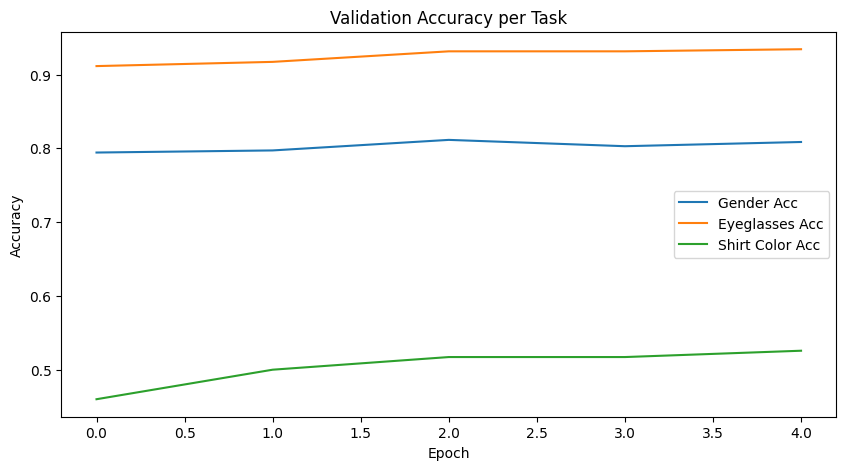

✅ Model saved to /content/drive/MyDrive/face_features_project/model_multitask_resnet.pth


In [ ]:
# ==========================================
#  Setup & Imports
# ==========================================
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

# ==========================================
#  Load annotated CSV & encode
# ==========================================
CSV_PATH = '/content/drive/MyDrive/face_features_project/data/fairface_labels_annotated.csv'
DATA_DIR = '/content/drive/MyDrive/face_features_project/data/fairface_subset/'

df = pd.read_csv(CSV_PATH)

# Drop any missing labels (if not annotated)
df = df.dropna(subset=['gender', 'eyeglasses', 'shirt_color'])

# Encode shirt_color to numeric
shirt_color_encoder = LabelEncoder()
df['shirt_color_encoded'] = shirt_color_encoder.fit_transform(df['shirt_color'])

print("✅ Encoded shirt_color classes:", list(shirt_color_encoder.classes_))

# ==========================================
#  Datasets & Transforms
# ==========================================
class FaceDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.df = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row['filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # gender and eyeglasses as float tensors
        gender = torch.tensor(row['gender'], dtype=torch.float32)
        eyeglasses = torch.tensor(row['eyeglasses'], dtype=torch.float32)
        shirt_color = torch.tensor(row['shirt_color_encoded'], dtype=torch.long)
        return image, gender, eyeglasses, shirt_color

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# ==========================================
#  Split Dataset & create Loaders
# ==========================================
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_ds = FaceDataset(train_df, DATA_DIR, transform)
val_ds = FaceDataset(val_df, DATA_DIR, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# ==========================================
#  Built Multi-Task ResNet
# ==========================================
class MultiTaskResNet(nn.Module):
    def __init__(self, num_colors):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # remove last layer
        self.gender_head = nn.Linear(512, 1)
        self.eyeglasses_head = nn.Linear(512, 1)
        self.shirt_color_head = nn.Linear(512, num_colors)

    def forward(self, x):
        features = self.backbone(x)
        gender = torch.sigmoid(self.gender_head(features))
        eyeglasses = torch.sigmoid(self.eyeglasses_head(features))
        shirt_color = self.shirt_color_head(features)
        return gender, eyeglasses, shirt_color

num_colors = len(shirt_color_encoder.classes_)
model = MultiTaskResNet(num_colors).cuda()


# ==========================================
#  Loss & Optimizer
# ==========================================
criterion_bce = nn.BCELoss()
criterion_ce = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ==========================================
#  Train Loop
# ==========================================
from sklearn.metrics import accuracy_score

# Initialize metrics lists
val_gender_accs, val_eyeglasses_accs, val_shirt_color_accs = [], [], []
train_losses, val_losses = [], []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, gender, eyeglasses, shirt_color in train_loader:
        images = images.cuda()
        gender = gender.cuda()
        eyeglasses = eyeglasses.cuda()
        shirt_color = shirt_color.cuda()

        optimizer.zero_grad()
        pred_gender, pred_eyeglasses, pred_shirt_color = model(images)

        loss_gender = criterion_bce(pred_gender.squeeze(), gender)
        loss_eyeglasses = criterion_bce(pred_eyeglasses.squeeze(), eyeglasses)
        loss_shirt_color = criterion_ce(pred_shirt_color, shirt_color)

        loss = loss_gender + loss_eyeglasses + loss_shirt_color
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_epoch_loss = 0
    gender_preds, gender_labels = [], []
    eyeglasses_preds, eyeglasses_labels = [], []
    shirt_color_preds, shirt_color_labels = [], []

    with torch.no_grad():
        for images, gender, eyeglasses, shirt_color in val_loader:
            images = images.cuda()
            gender = gender.cuda()
            eyeglasses = eyeglasses.cuda()
            shirt_color = shirt_color.cuda()

            pred_gender, pred_eyeglasses, pred_shirt_color = model(images)

            loss_gender = criterion_bce(pred_gender.squeeze(), gender)
            loss_eyeglasses = criterion_bce(pred_eyeglasses.squeeze(), eyeglasses)
            loss_shirt_color = criterion_ce(pred_shirt_color, shirt_color)

            loss = loss_gender + loss_eyeglasses + loss_shirt_color
            val_epoch_loss += loss.item()

            # Collect predictions
            gender_preds.extend((pred_gender.squeeze()>0.5).cpu().numpy())
            gender_labels.extend(gender.cpu().numpy())

            eyeglasses_preds.extend((pred_eyeglasses.squeeze()>0.5).cpu().numpy())
            eyeglasses_labels.extend(eyeglasses.cpu().numpy())

            shirt_color_preds.extend(torch.argmax(pred_shirt_color, dim=1).cpu().numpy())
            shirt_color_labels.extend(shirt_color.cpu().numpy())

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute accuracies
    gender_acc = accuracy_score(gender_labels, gender_preds)
    eyeglasses_acc = accuracy_score(eyeglasses_labels, eyeglasses_preds)
    shirt_color_acc = accuracy_score(shirt_color_labels, shirt_color_preds)

    val_gender_accs.append(gender_acc)
    val_eyeglasses_accs.append(eyeglasses_acc)
    val_shirt_color_accs.append(shirt_color_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
    print(f"  Gender Acc: {gender_acc:.3f} | Eyeglasses Acc: {eyeglasses_acc:.3f} | Shirt Color Acc: {shirt_color_acc:.3f}")


# ==========================================
#  Plot Loss Curves
# ==========================================
plt.figure(figsize=(10,5))
plt.plot(val_gender_accs, label='Gender Acc')
plt.plot(val_eyeglasses_accs, label='Eyeglasses Acc')
plt.plot(val_shirt_color_accs, label='Shirt Color Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Task')
plt.legend()
plt.show()


# ==========================================
#  Saving Model & Weights
# ==========================================
MODEL_PATH = '/content/drive/MyDrive/face_features_project/model_multitask_resnet.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")

# Run Inference on Model


In [ ]:
# Install gdown for downloading model from google drive
!pip install -q gdown

# Download model from the public Google Drive link
!gdown 'https://drive.google.com/uc?id=1UFDFWbFkQ7nOJSYmEzxrGo0B9J3qbtZu' -O model_multitask_resnet.pth

In [ ]:

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Define label encoder (use same order as training)
shirt_color_encoder = LabelEncoder()
shirt_color_encoder.classes_ = np.array(['black', 'blue', 'brown', 'gray', 'green',
                                        'other', 'pink', 'purple', 'red', 'white', 'yellow'])

# Define model
class MultiTaskResNet(nn.Module):
    def __init__(self, num_colors):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.fc = nn.Identity()
        self.gender_head = nn.Linear(512, 1)
        self.eyeglasses_head = nn.Linear(512, 1)
        self.shirt_color_head = nn.Linear(512, num_colors)
    def forward(self, x):
        features = self.backbone(x)
        gender = torch.sigmoid(self.gender_head(features))
        eyeglasses = torch.sigmoid(self.eyeglasses_head(features))
        shirt_color = self.shirt_color_head(features)
        return gender, eyeglasses, shirt_color

# Load model
model = MultiTaskResNet(num_colors=len(shirt_color_encoder.classes_))
model.load_state_dict(torch.load('model_multitask_resnet.pth', map_location='cpu'))
model.eval()

# Upload image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocess
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])
image = Image.open(img_path).convert('RGB')
image = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    pred_gender, pred_eyeglasses, pred_shirt_color = model(image)
    gender = "Male" if pred_gender.item()<0.5 else "Female"   # dataset uses 0=male
    eyeglasses = "Yes" if pred_eyeglasses.item()>0.5 else "No"
    shirt_color_idx = torch.argmax(pred_shirt_color, dim=1).item()
    shirt_color = shirt_color_encoder.inverse_transform([shirt_color_idx])[0]

print(f"✅ Prediction: Gender: {gender}, Eyeglasses: {eyeglasses}, Shirt color: {shirt_color}")


Downloading...
From (original): https://drive.google.com/uc?id=1UFDFWbFkQ7nOJSYmEzxrGo0B9J3qbtZu
From (redirected): https://drive.google.com/uc?id=1UFDFWbFkQ7nOJSYmEzxrGo0B9J3qbtZu&confirm=t&uuid=3a109487-fe8f-4fce-b9fd-de9ea0ec314a
To: /content/model_multitask_resnet.pth
100% 44.8M/44.8M [00:00<00:00, 112MB/s]


Saving IMG_20241206_120808~2.jpg to IMG_20241206_120808~2.jpg
✅ Prediction: Gender: Male, Eyeglasses: Yes, Shirt color: black
